In [3]:
from fastai.vision import *
from sklearn.model_selection import StratifiedKFold
from fastai.callbacks import *
from fastai.tabular import *

In [6]:
csv_path = '/disks/data/paper_projects/selfie_detection/data/DS_224_all_features_no_duplicates/dlib_faces/'

image_path = '/disks/data/paper_projects/selfie_detection/data/DS_224_all_features_no_duplicates/color_skeleton/im+skeleton/'

class_names = ['selfie', 'non_selfie', 'mirror_selfie', 'non_mirror_selfie']

class_dataframes = {}

for class_name in class_names:
    csv = pd.read_csv(csv_path+class_name+'.csv')
    csv.insert(0, column = 'class_label',value = len(csv.index)*[f"{class_name}"])
    csv['path'] = csv.class_label + '/' + csv.im_skeleton
    csv = csv.drop(['im_skeleton'], axis = 1)
    class_dataframes[class_name] = csv

In [7]:
[class_dataframe.shape for _, class_dataframe in class_dataframes.items()] 

[(1788, 153), (1249, 153), (1171, 153), (1335, 153)]

In [8]:
class_dataframes.keys()

dict_keys(['selfie', 'non_selfie', 'mirror_selfie', 'non_mirror_selfie'])

In [9]:
class_dataframes[class_names[3]].shape

(1335, 153)

In [11]:
selfie_df = class_dataframes['selfie'].sample(n=len(class_dataframes['non_selfie'].index), replace=False, random_state=4, axis=0)

print(selfie_df.shape)
#newdf = class_dataframes['selfie'].copy().append(class_dataframes['non_selfie'])
newdf = selfie_df.append(class_dataframes['non_selfie'])

(1249, 153)


In [12]:
print(newdf.shape)
newdf.head()

(2498, 153)


,class_label,im_name,x_min,y_min,x_max,y_max,confidence_score,yaw,pitch,roll,...,y_65,x_66,y_66,x_67,y_67,x_68,y_68,skeleton,im_masked,path
1255,selfie,selfie_mshah_0002888.jpg,51.794823,7.731789,167.835022,149.212799,NaN,12.702850,-17.375320,-20.544289,...,75,91,86,86,88,81,87,selfie_mshah_0002888.jpg_skeleton.jpg,selfie_mshah_0002888.jpg_masked.jpg,selfie/selfie_mshah_0002888.jpg_im_skeleton.jpg
1757,selfie,selfie_mshah_0000260.jpg,80.503311,81.839630,205.567429,242.020813,NaN,-1.656120,-22.516785,-5.354843,...,152,113,157,107,158,102,158,selfie_mshah_0000260.jpg_skeleton.jpg,selfie_mshah_0000260.jpg_masked.jpg,selfie/selfie_mshah_0000260.jpg_im_skeleton.jpg
1226,selfie,selfie_mshah_0038322.jpg,99.380798,42.433990,219.251373,208.734207,NaN,1.438683,-10.838379,-1.524521,...,126,124,128,118,129,112,128,selfie_mshah_0038322.jpg_skeleton.jpg,selfie_mshah_0038322.jpg_masked.jpg,selfie/selfie_mshah_0038322.jpg_im_skeleton.jpg
554,selfie,selfie_mshah_0038357.jpg,90.119972,78.243149,234.852600,271.807312,NaN,6.548569,0.761742,6.543167,...,169,120,168,115,167,111,167,selfie_mshah_0038357.jpg_skeleton.jpg,selfie_mshah_0038357.jpg_masked.jpg,selfie/selfie_mshah_0038357.jpg_im_skeleton.jpg
230,selfie,selfie_tag_11316283405_d8fd776a2b_c.jpg,94.707085,74.440269,213.292572,216.627594,NaN,3.877739,6.659058,0.466476,...,137,116,136,111,137,106,137,selfie_tag_11316283405_d8fd776a2b_c.jpg_skelet...,selfie_tag_11316283405_d8fd776a2b_c.jpg_masked...,selfie/selfie_tag_11316283405_d8fd776a2b_c.jpg...


In [13]:
def _normalize_images_batch(b:Tuple[Tensor,Tensor], mean:FloatTensor, std:FloatTensor)->Tuple[Tensor,Tensor]:
    "`b` = `x`,`y` - normalize `x` array of imgs and `do_y` optionally `y`."
    x,y = b
    mean,std = mean.to(x[0].device),std.to(x[0].device)
    x[0] = normalize(x[0],mean,std)
    return x,y

def normalize_custom_funcs(mean:FloatTensor, std:FloatTensor, do_x:bool=True, do_y:bool=False)->Tuple[Callable,Callable]:
    "Create normalize/denormalize func using `mean` and `std`, can specify `do_y` and `device`."
    mean,std = tensor(mean),tensor(std)
    return (partial(_normalize_images_batch, mean=mean, std=std),
            partial(denormalize, mean=mean, std=std))

In [14]:
imgList = ImageList.from_df(newdf, path=image_path, cols='path')

In [21]:
cont_vars = selfie_df.columns[7:-3]

In [22]:
tabList = TabularList.from_df(newdf, cat_names=[], cont_names=cont_vars, procs=[Normalize])

In [23]:
mixed = MixedItemList([imgList, tabList], image_path, inner_df=imgList.inner_df)\
.split_by_rand_pct(.2)\
.label_from_df(cols='class_label')
#.transform([[get_transforms()[0], []], [get_transforms()[1], []]], size=224)

data = mixed.databunch(no_check=True, bs=64, num_workers=0) # num_workers=0 here just to get errors more quickly

In [24]:
data.classes

['non_selfie', 'selfie']

In [25]:
norm, denorm = normalize_custom_funcs(*imagenet_stats)
data.add_tfm(norm) # normalize images

In [26]:
item, labels = next(iter(data.train_dl))

In [27]:
# item[1][0], item[1][1]
mixed.train.x.item_lists[1].get_emb_szs()

[]

In [28]:
print(*imagenet_stats)

[0.485, 0.456, 0.406] [0.229, 0.224, 0.225]


In [29]:
emb = mixed.train.x.item_lists[1].get_emb_szs()

In [30]:
# from fastai.torch_core import *
# from fastai.vision import *
# from fastai.tabular.models import *
# from fastai.tabular import *
# from fastai.layers import *
# import torch

# class ImageTabularModel(nn.Module):
#     "Basic model for tabular data."
#     def __init__(self, emb_szs:ListSizes, n_cont:int, layers:Collection[int], ps:Collection[float]=None):
#         super().__init__()
#         self.cnn = create_body(models.resnet34)
#         self.tab = TabularModel({}, n_cont, 128, [512, 356]) #TabularModel(emb_szs, n_cont, 512, layers, ps)

#         self.reduce = nn.Sequential(*([Flatten()] + bn_drop_lin((512*7*7), 512, bn=True, p=0.5, actn=nn.ReLU(inplace=True))))
#         self.merge = nn.Sequential(*bn_drop_lin(512 + 512, 1024, bn=True, p=0.5, actn=nn.ReLU(inplace=True)))
#         self.final = nn.Sequential(*bn_drop_lin(1024, 2, bn=True, p=0., actn=nn.ReLU(inplace=True)))

#     def forward(self, img:Tensor, x_cat:Tensor, x_cont:Tensor) -> Tensor:
#         imgLatent = self.reduce(self.cnn(img))
#         tabLatent = self.tab(x_cat, x_cont)

#         cat = torch.cat(imgLatent, tabLatent)

#         return self.final(self.merge(cat))

In [31]:
def split_layers(model:nn.Module) -> List[nn.Module]:
    groups = [[model.cnn]]
    groups += [[model.tab, model.reduce, model.merge, model.final]]
    return groups

class ImageTabularTextLearner(Learner):
    def __init__(self, data:DataBunch, model:nn.Module, alpha:float=2., beta:float=1., **learn_kwargs):
        super().__init__(data, model, **learn_kwargs)
        self.split(split_layers)

In [48]:
class ImageTabularTextModel(nn.Module):
    def __init__(self, n_cont:int):
        super().__init__()
        self.cnn = create_body(models.resnet34)
        nf = num_features_model(self.cnn) * 2
        drop = .5

        self.tab = TabularModel({}, n_cont, 128, [512, 512, 256])

        self.reduce = nn.Sequential(*([AdaptiveConcatPool2d(), Flatten()] + bn_drop_lin(nf, 512, bn=True, p=drop, actn=nn.ReLU(inplace=True))))
        self.merge = nn.Sequential(*bn_drop_lin(512 + 128, 128, bn=True, p=drop, actn=nn.ReLU(inplace=True)))
        self.final = nn.Sequential(*bn_drop_lin(128, 2, bn=False, p=0., actn=None))
        #self.final = nn.Sequential(*bn_drop_lin(512, 2, bn=False, p=0., actn=None))
        #print(self)
        
    def forward(self, img:Tensor, x:Tensor) -> Tensor:
        #print(img.shape)        
        imgCnn = self.cnn(img)
        #print(imgCnn.shape)
        imgLatent = self.reduce(imgCnn)
        #print(imgLatent.shape)
        tabLatent = self.tab(x[0], x[1])
        #print(tabLatent.shape)
        
        cat = torch.cat([imgLatent, F.relu(tabLatent)], dim=1)
        #print(cat.shape)
        
        pred = self.final(self.merge(cat))
        #pred = torch.sigmoid(pred)  # making sure this is in the range 0-4
        #pred = torch.sigmoid(self.final(self.reduce(imgCnn)))
        #print(pred)
        return pred #torch.softmax(torxh.zeros(1,2))
        
    def reset(self):
        for c in self.children():
            if hasattr(c, 'reset'): c.reset()

In [49]:
model = ImageTabularTextModel(len(cont_vars))
learn = ImageTabularTextLearner(data, model, metrics=[error_rate])

In [50]:
# it = iter(data.valid_dl)
# for item, label in it:
#     print(label)

In [51]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


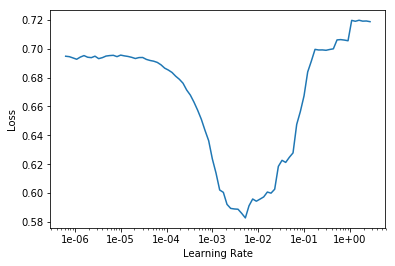

In [52]:
learn.recorder.plot()

In [53]:
learn.fit_one_cycle(10, .4e-3)

epoch,train_loss,valid_loss,error_rate,time
0,0.644326,0.588550,0.188377,00:08
1,0.437755,0.248324,0.096192,00:08
2,0.277291,0.531088,0.182365,00:08
3,0.196097,0.518633,0.176353,00:08
4,0.140534,0.362858,0.114228,00:08
5,0.098261,0.317008,0.098196,00:08
6,0.072811,0.325145,0.102204,00:08
7,0.045126,0.305593,0.082164,00:08
8,0.025878,0.293106,0.074148,00:08
9,0.015895,0.296829,0.076152,00:08


In [54]:
learn.save('resnet34_stage_1_im_sk_ypr_dlib')
# learn.fit_one_cycle(5, .7e-3)
learn.load('resnet34_stage_1_im_sk_ypr_dlib');

In [55]:
learn.unfreeze()

In [56]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


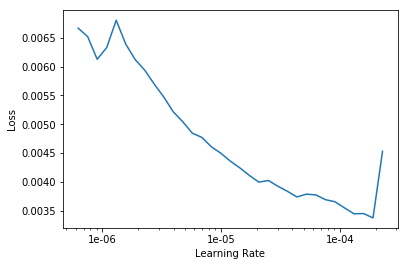

In [57]:
learn.recorder.plot()

In [58]:
learn.fit_one_cycle(10, max_lr=slice(1e-6,1e-6/3))

epoch,train_loss,valid_loss,error_rate,time
0,0.004695,0.298407,0.078156,00:08
1,0.004869,0.294852,0.076152,00:08
2,0.004263,0.294065,0.074148,00:08
3,0.003870,0.297396,0.078156,00:08
4,0.005847,0.296084,0.072144,00:08
5,0.004345,0.298737,0.072144,00:08
6,0.003790,0.298913,0.072144,00:08
7,0.004970,0.297645,0.074148,00:08
8,0.005695,0.299446,0.078156,00:08
9,0.004873,0.296726,0.072144,00:08


In [60]:
learn.save('resnet34_stage_2_im_sk_ypr_dlib')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


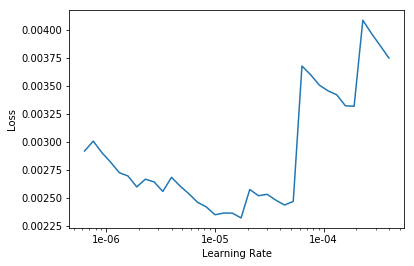

In [59]:
learn.lr_find()
learn.recorder.plot()

In [61]:
learn.fit_one_cycle(10, max_lr=slice(.8e-6,.8e-6/3))

epoch,train_loss,valid_loss,error_rate,time
0,0.003243,0.299183,0.074148,00:08
1,0.002898,0.297075,0.072144,00:08
2,0.003435,0.300199,0.078156,00:08
3,0.003472,0.300865,0.076152,00:08
4,0.004625,0.300685,0.074148,00:08
5,0.004842,0.299041,0.074148,00:08
6,0.003964,0.299066,0.070140,00:08
7,0.003784,0.298916,0.078156,00:08
8,0.003373,0.296978,0.074148,00:08
9,0.003082,0.301354,0.076152,00:08


In [62]:
interp = ClassificationInterpretation.from_learner(learn)

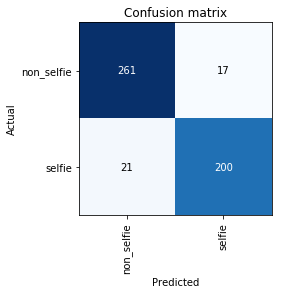

In [63]:
interp.plot_confusion_matrix()

In [64]:
confusion_mat = interp.confusion_matrix()
confusion_mat/np.sum(confusion_mat, axis = 1).reshape(-1,1)

array([[0.938849, 0.061151],
       [0.095023, 0.904977]])

In [57]:
len(data.train_ds), len(data.valid_ds)

(2440, 609)